# FORECASTING FOR MONTHLY-PROVINCE-DEPARTMENT DIMENSION                                        USING AUTO-ARIMA MODEL

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from workalendar.america import Canada
import datetime
sns.set(rc={'figure.figsize':(16, 5)})

In [38]:
#loading the data from csv file
data= '../data/dataset-02.csv'
df = pd.read_csv(data,)


# Using Last 12 Months As Validation Set And Remaining Data As Training Set.

1. using auto-arima model which does random search over parameters(p,q) (range of p and q is from 0-3).
2. seasonality is removed by differencing(parameter 'm' in the model).


In [39]:
#selecting the required dimensions.
df1 = df[['year','month','province', 'department', 'totalSales']]
df1 = df1.groupby(['year','month', 'province', 'department']).agg({'totalSales': 'sum'}).reset_index()
df_duplicate = df1

provinces = df1.province.unique()

actual_list = []
forecast_list = []
title_list = []

#performing modelling
for i in provinces:
    df1 = df_duplicate
    df1_find_departments = df1[(df1['province'] == i)]
    departments = df1_find_departments.department.unique()

    for j in departments:
    
        df1 = df1[(df1['province'] == i) & (df1['department'] == j)]
        df1['date'] = pd.to_datetime(df1['year'].astype(str)  + df1['month'].astype(str), format='%Y%m')
        df1['date'] = df1['date'].apply(lambda x: x.strftime('%Y-%m'))
        df1 = df1.set_index('date')
        df1 = df1['totalSales'].to_frame()
        df1 = df1.reset_index()
        start_year = df1.date[0]
        start_year = int(start_year[0:4])
        end_year = df1.date[len(df1)-1]
        end_year = int(end_year[0:4])
        df1 = df1.set_index('date')

        if len(df1) < 36:
            df1 = df_duplicate
            continue
        else:
            #generating dummy df to fill missed values with zeroes
            start = datetime.datetime(start_year, 1, 1)
            end = datetime.datetime(end_year, 1, 1)
            num_months = (end.year - start.year) * 12 + (end.month - start.month) + 1
            rang = pd.date_range(start,end, freq='MS').strftime("%Y-%m")
            indx = pd.Series([0]*num_months, rang)
            generated_df = pd.DataFrame(indx, columns=["totalSales"])
            generated_df = generated_df.reset_index()
            generated_df = generated_df.rename(columns={"index": "date"})
            generated_df = generated_df.set_index('date')

            #merging genearted and original to fill zeroes
            generated_df1 = pd.merge(df1, generated_df, left_index=True, right_index=True, how="right")
            generated_df1 = generated_df1.reset_index()
            generated_df1 = generated_df1.drop(['totalSales_y'], axis = 1)
            generated_df1 = generated_df1.rename(columns={"totalSales_x": "totalSales"})
            generated_df1['totalSales'] = generated_df1['totalSales'].fillna(0.0)
            generated_df1 = generated_df1.set_index('date')

            #preparing data
            generated_df = generated_df1
            test = generated_df.tail(12)
            train = generated_df.head(len(generated_df)-12)

            #using auto-arima model which does random search over parameters(p,q). 
            #seasonality is removed by differencing(parameter 'm' in the model).  
            stepwise_model = auto_arima(train, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',
                               suppress_warnings=True, 
                               stepwise=True)

            model = stepwise_model.fit(train)

            #predicting sales
            future_forecast = model.predict(n_periods=12)
            future_forecast = future_forecast.tolist()
            forecast_list.append(future_forecast)
            actual = test['totalSales'].tolist()
            actual_list.append(actual)
            title_list.append(i+'-'+j)
            
            future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predictedSales']
            df1 = df_duplicate

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1224.971, BIC=1234.327, Time=0.621 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1223.953, BIC=1227.695, Time=0.033 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1225.712, BIC=1233.197, Time=0.524 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1225.105, BIC=1232.590, Time=0.276 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1223.450, BIC=1225.321, Time=0.026 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1224.410, BIC=1230.024, Time=0.142 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1223.682, BIC=1229.296, Time=0.213 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1221.921, BIC=1229.406, Time=0.594 seconds
Fit ARIMA: (0, 1, 0)x(2, 1, 1, 12) (constant=True); AIC=1222.924, BIC=1232.280, Time=1.393 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 2, 12) (constant=True); AIC=1223.040,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1075.205, BIC=1084.561, Time=0.431 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1080.460, BIC=1084.203, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1078.271, BIC=1085.756, Time=0.215 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1074.510, BIC=1081.995, Time=0.239 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1078.515, BIC=1080.386, Time=0.055 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1079.181, BIC=1084.795, Time=0.080 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1073.487, BIC=1082.843, Time=0.651 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1076.520, BIC=1084.005, Time=0.207 seconds
Fit ARIMA: (0, 1, 1)x(2, 1, 1, 12) (constant=True); AIC=1075.055, BIC=1086.283, Time=1.251 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=1074.889,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1065.177, BIC=1074.533, Time=1.010 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1073.450, BIC=1077.193, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1072.555, BIC=1080.040, Time=0.252 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1069.772, BIC=1077.257, Time=0.380 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1071.510, BIC=1073.381, Time=0.048 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1069.623, BIC=1077.108, Time=0.393 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1065.196, BIC=1076.423, Time=1.776 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse r

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1324.574, BIC=1333.930, Time=0.964 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1325.175, BIC=1328.918, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1326.138, BIC=1333.623, Time=0.198 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1325.242, BIC=1332.727, Time=0.245 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1324.686, BIC=1326.558, Time=0.030 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1326.286, BIC=1333.771, Time=0.428 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1324.129, BIC=1335.356, Time=1.301 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1325.493, BIC=1334.849, Time=0.927 seconds
Near 

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1238.216, BIC=1247.572, Time=0.508 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1236.972, BIC=1240.715, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1236.588, BIC=1244.072, Time=0.244 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1236.849, BIC=1244.334, Time=0.334 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1236.503, BIC=1238.374, Time=0.025 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1236.880, BIC=1242.494, Time=0.115 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1236.902, BIC=1242.515, Time=0.175 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1238.866, BIC=1246.351, Time=0.454 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1236.252, BIC=1241.865, Time=0.089 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1236.722,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1218.091, BIC=1227.447, Time=0.751 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1223.768, BIC=1227.510, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1223.595, BIC=1231.080, Time=0.245 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1218.533, BIC=1226.017, Time=0.416 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1223.264, BIC=1225.135, Time=0.026 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1223.405, BIC=1230.890, Time=0.349 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1212.970, BIC=1224.198, Time=1.191 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1221.634, BIC=1230.990, Time=0.965 seconds
Near non-invertible roots for order (1, 1, 1)(1,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1151.127, BIC=1160.483, Time=0.361 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1147.848, BIC=1151.590, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1148.975, BIC=1156.459, Time=0.203 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1149.107, BIC=1156.592, Time=0.195 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1148.239, BIC=1150.110, Time=0.032 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1148.567, BIC=1154.180, Time=0.152 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1148.411, BIC=1154.025, Time=0.177 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1150.406, BIC=1157.891, Time=0.339 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1147.517, BIC=1153.130, Time=0.072 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1148.977,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=529.576, BIC=535.467, Time=0.341 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=527.116, BIC=529.472, Time=0.030 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=529.222, BIC=533.935, Time=0.172 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=527.834, BIC=532.546, Time=0.245 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=526.235, BIC=527.413, Time=0.041 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=527.090, BIC=530.624, Time=0.109 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=525.142, BIC=528.676, Time=0.159 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=526.222, BIC=530.934, Time=0.294 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 2, 12) (constant=True); AIC=525.738, BIC=530.451, Time=0.452 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 2, 12) (constant=True); AIC=527.715, BIC=533.606, Time=0.837 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1264.289, BIC=1273.645, Time=0.285 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1261.501, BIC=1265.244, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1262.064, BIC=1269.549, Time=0.200 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1262.256, BIC=1269.741, Time=0.259 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1261.034, BIC=1262.905, Time=0.025 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1260.083, BIC=1265.697, Time=0.131 seconds
Fit ARIMA: (0, 1, 0)x(2, 1, 0, 12) (constant=True); AIC=1262.083, BIC=1269.568, Time=0.463 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1261.699, BIC=1269.184, Time=0.519 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1260.079, BIC=1265.692, Time=0.168 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 2, 12) (constant=True); AIC=1262.070,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1163.897, BIC=1173.253, Time=0.538 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1176.554, BIC=1180.296, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1171.427, BIC=1178.911, Time=0.219 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1165.554, BIC=1173.038, Time=0.333 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1176.051, BIC=1177.922, Time=0.024 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1173.243, BIC=1180.728, Time=0.670 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1164.014, BIC=1175.241, Time=0.817 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=1163.352, BIC=1174.579, Time=1.433 seconds
Fit A

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1151.166, BIC=1160.522, Time=0.811 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1159.381, BIC=1163.124, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1157.055, BIC=1164.540, Time=0.230 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1154.165, BIC=1161.649, Time=0.288 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1158.916, BIC=1160.788, Time=0.025 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1157.786, BIC=1165.271, Time=0.541 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1152.424, BIC=1163.651, Time=0.955 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=1151.495, BIC=1162.722, Time=1.784 seconds
Fit A

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1402.525, BIC=1411.881, Time=0.503 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1403.983, BIC=1407.726, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1401.233, BIC=1408.718, Time=0.228 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1400.877, BIC=1408.362, Time=0.289 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1403.479, BIC=1405.350, Time=0.024 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1405.182, BIC=1410.795, Time=0.074 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1402.661, BIC=1412.017, Time=0.612 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=1402.727, BIC=1412.083, Time=0.835 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1401.260, BIC=1408.745, Time=0.209 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=1404.658,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1341.662, BIC=1351.018, Time=0.542 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1344.409, BIC=1348.152, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1340.651, BIC=1348.136, Time=0.240 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1339.952, BIC=1347.437, Time=0.242 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1343.909, BIC=1345.780, Time=0.027 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1341.429, BIC=1347.043, Time=0.083 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1341.433, BIC=1350.789, Time=0.564 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=1341.757, BIC=1351.113, Time=0.604 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1339.703, BIC=1347.188, Time=0.202 seconds
Fit ARIMA: (0, 1, 1)x(2, 1, 0, 12) (constant=True); AIC=1341.579,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1336.392, BIC=1345.748, Time=0.916 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1336.711, BIC=1340.453, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1339.083, BIC=1346.568, Time=0.230 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1334.727, BIC=1342.212, Time=0.247 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1336.208, BIC=1338.079, Time=0.026 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1337.738, BIC=1343.351, Time=0.065 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1334.299, BIC=1343.655, Time=0.592 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1339.016, BIC=1346.501, Time=0.238 seconds
Fit ARIMA: (0, 1, 1)x(2, 1, 1, 12) (constant=True); AIC=1330.728, BIC=1341.955, Time=1.022 seconds
Fit ARIMA: (0, 1, 1)x(2, 1, 0, 12) (constant=True); AIC=1331.389,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1202.299, BIC=1211.655, Time=0.712 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1198.905, BIC=1202.648, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1199.797, BIC=1207.281, Time=0.205 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1200.291, BIC=1207.775, Time=0.219 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1199.796, BIC=1201.668, Time=0.034 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1198.159, BIC=1203.773, Time=0.130 seconds
Fit ARIMA: (0, 1, 0)x(2, 1, 0, 12) (constant=True); AIC=1199.478, BIC=1206.963, Time=0.553 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1197.806, BIC=1205.291, Time=0.539 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1198.755, BIC=1204.368, Time=0.154 seconds
Fit ARIMA: (0, 1, 0)x(2, 1, 1, 12) (constant=True); AIC=1199.716,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=576.678, BIC=582.569, Time=0.530 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=582.628, BIC=584.984, Time=0.027 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=573.221, BIC=577.933, Time=0.199 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=575.294, BIC=580.007, Time=0.241 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=582.327, BIC=583.505, Time=0.041 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=584.579, BIC=588.113, Time=0.051 seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 0, 12) (constant=True); AIC=574.813, BIC=580.704, Time=0.489 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=574.726, BIC=580.616, Time=0.329 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=573.331, BIC=578.043, Time=0.218 seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 1, 12) (constant=True); AIC=576.659, BIC=583.727, Time=

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1180.028, BIC=1189.384, Time=0.538 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1179.488, BIC=1183.230, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1182.267, BIC=1189.752, Time=0.198 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1181.236, BIC=1188.721, Time=0.259 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1178.987, BIC=1180.858, Time=0.024 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1180.477, BIC=1186.091, Time=0.132 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1179.649, BIC=1185.262, Time=0.188 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1177.604, BIC=1185.089, Time=0.492 seconds
Fit ARIMA: (0, 1, 0)x(2, 1, 1, 12) (constant=True); AIC=1177.198, BIC=1186.554, Time=2.471 seconds
Fit ARIMA: (0, 1, 0)x(2, 1, 0, 12) (constant=True); AIC=1176.477,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1057.973, BIC=1067.329, Time=0.535 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1077.758, BIC=1081.501, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1070.841, BIC=1078.325, Time=0.227 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1060.079, BIC=1067.563, Time=0.274 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1075.813, BIC=1077.684, Time=0.048 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1074.604, BIC=1082.089, Time=0.195 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1057.814, BIC=1069.041, Time=0.750 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1066.251, BIC=1075.607, Time=0.535 seconds
Fit ARIMA: (1, 1, 1)x(2, 1, 1, 12) (constant=True); AIC=1058.386, BIC=1071.485, Time=2.071 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=1058.819,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1033.263, BIC=1042.619, Time=0.484 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1043.563, BIC=1047.306, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1033.173, BIC=1040.658, Time=0.232 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1032.578, BIC=1040.063, Time=0.337 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1041.621, BIC=1043.492, Time=0.048 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1045.751, BIC=1051.364, Time=0.083 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1034.422, BIC=1043.778, Time=0.479 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=1034.470, BIC=1043.826, Time=0.758 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1033.086, BIC=1040.571, Time=0.204 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=1036.365,

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1278.697, BIC=1288.053, Time=1.543 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1275.775, BIC=1279.518, Time=0.031 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1279.237, BIC=1286.722, Time=0.240 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1279.153, BIC=1286.638, Time=0.217 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1275.280, BIC=1277.152, Time=0.030 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1277.228, BIC=1282.841, Time=0.149 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1277.142, BIC=1282.755, Time=0.176 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1275.122, BIC=1282.607, Time=0.526 seconds
Near non-invertible roots for order (0, 1, 0)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit A

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1189.624, BIC=1198.980, Time=0.511 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1192.190, BIC=1195.932, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1186.669, BIC=1194.154, Time=0.245 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1188.156, BIC=1195.641, Time=0.309 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1191.732, BIC=1193.603, Time=0.024 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1185.138, BIC=1190.752, Time=0.107 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1186.732, BIC=1194.217, Time=0.235 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1186.736, BIC=1196.092, Time=0.935 seconds
Near non-invertible roots for order (1, 1, 0)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit A

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1193.787, BIC=1203.143, Time=0.470 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1192.004, BIC=1195.746, Time=0.032 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1195.016, BIC=1202.500, Time=0.233 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1192.680, BIC=1200.165, Time=0.254 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1191.508, BIC=1193.379, Time=0.026 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1193.124, BIC=1198.738, Time=0.148 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=1191.251, BIC=1196.865, Time=0.162 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=1185.690, BIC=1193.174, Time=0.566 seconds
Fit ARIMA: (0, 1, 0)x(2, 1, 1, 12) (constant=True); AIC=1183.459, BIC=1192.815, Time=0.920 seconds
Fit ARIMA: (0, 1, 0)x(2, 1, 0, 12) (constant=True); AIC=1185.985, BIC=1193.470, Time=0.381 seconds
Fit ARIMA

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1103.859, BIC=1113.215, Time=0.396 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=1107.228, BIC=1110.970, Time=0.042 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=1102.410, BIC=1109.895, Time=0.205 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=1101.783, BIC=1109.267, Time=0.221 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=1106.977, BIC=1108.848, Time=0.048 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=1097.992, BIC=1103.605, Time=0.267 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=1101.502, BIC=1108.987, Time=0.206 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=1101.521, BIC=1110.877, Time=0.814 seconds
Near non-invertible roots for order (0, 1, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit A

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=522.038, BIC=527.928, Time=0.304 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=523.039, BIC=525.395, Time=0.030 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=526.732, BIC=531.445, Time=0.158 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=520.644, BIC=525.357, Time=0.205 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=522.067, BIC=523.245, Time=0.040 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=521.051, BIC=524.585, Time=0.067 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=520.891, BIC=526.781, Time=0.382 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=519.907, BIC=525.797, Time=0.456 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=521.900, BIC=528.968, Time=1.044 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 2, 12) (constant=True); AIC=521.901, BIC=526.613, Time=

/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/dell/anaconda3/envs/forecasting/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Plotting The Forecasted Results.

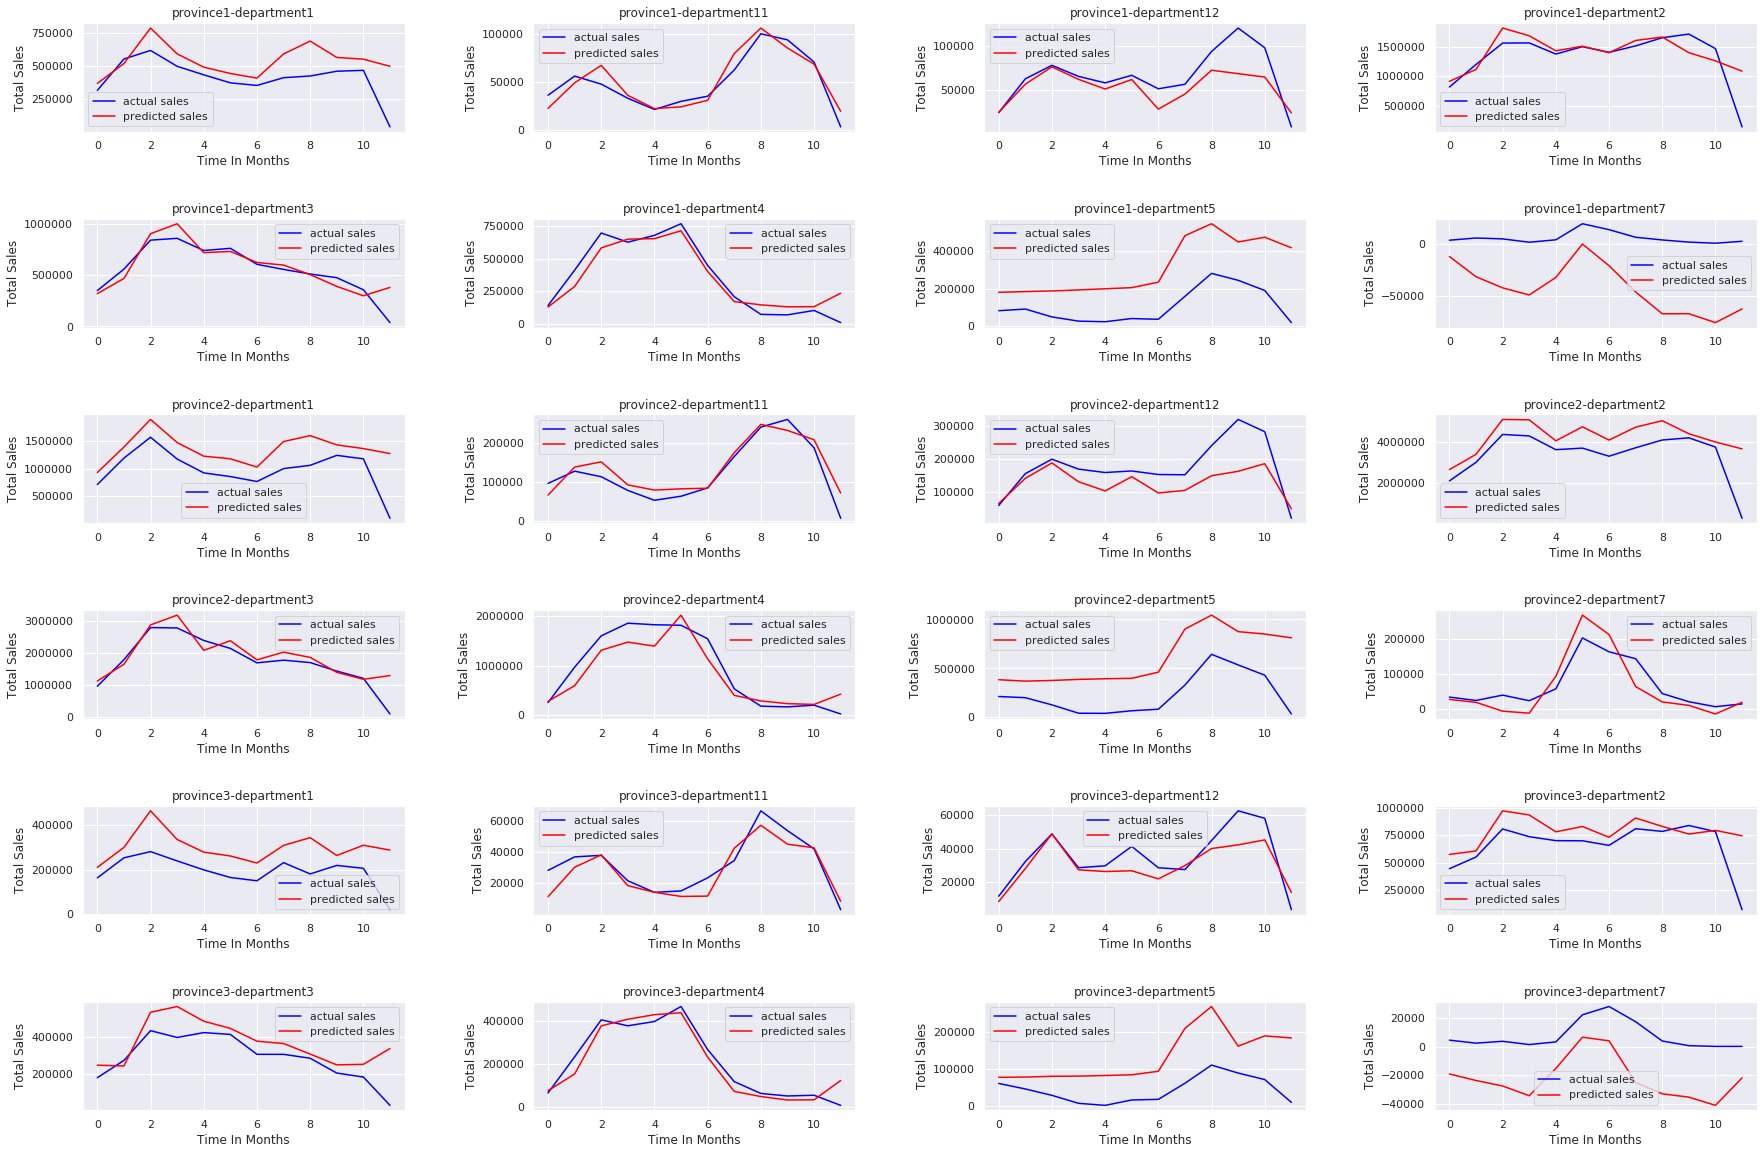

In [40]:
fig = plt.figure(figsize=(30,20))
fig.subplots_adjust(hspace=0.8, wspace=0.4)
i = 0
for i in range(1,len(actual_list)+1):
    ax = fig.add_subplot(6, 4, i)
    ax.plot(actual_list[i-1], c = 'blue', label = 'actual sales')
    ax.plot(forecast_list[i-1], c = 'red', label = 'predicted sales')
    ax.set_title(title_list[i-1])
    ax.set_xlabel('Time In Months')
    ax.set_ylabel('Total Sales')
    ax.legend()
plt.show()


In [41]:
fig.savefig('department.png')